In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [13]:
from process_raw_data import *

### Set up processing parameters

In [1]:
cellBCpath = '/wynton/scratch/bp205/barcodes/MK_barcode_identities.csv'
geneBCpath = '/wynton/scratch/bp205/barcodes/sample_barcodes/HCC_MK_multiseq_barcodes.txt'
matrixPath = '/wynton/scratch/bp205/raw/HCC_MK/filtered_gene_bc_matrices/GRCh38/'
outfilePath = '/wynton/scratch/bp205/processed/HCC_MK_filtered_normalized_adata.h5ad'

minN_genes = 200
minN_cells = 3
maxN_genes = 6000
maxMito_percent = 0.07

### Load Cell barcodes and Sample barcodes

In [6]:
cellBC = pd.read_csv(cellBCpath, usecols=[1,2,3])
cellBC = cellBC[cellBC['multiseq barcode']!='DOUBLET']

geneBC = pd.read_csv(geneBCpath, sep='\t', index_col=0)
BCmap = create_barcode_map(cellBC, geneBC)

In [7]:
BCmap.head()

,multiseq barcode,quality,SampleType
cell barcode,,,
GTGTAACGTTTAGAGA,ATCCCGCTACTCCGAACC,inf,BoM
TCAGCCTCAGCGTACC,ATCCCGCTACTCCGAACC,inf,BoM
CAAGACTTCGTCTACC,AGTACGCTGACCACGACA,inf,TGL
GGAAGTGCATACACCA,TGGTAACCGAGGACGACG,inf,LM2
ACACTGATCAATCCGA,AGTACGCTGACCACGACA,inf,TGL


### Loading raw sample x gene counts matrix

In [15]:
adata = read_matrix(matrixPath)

... reading from cache file cache/wynton-scratch-bp205-raw-MDA_BW-filtered_feature_bc_matrix-matrix.h5ad


In [16]:
adata = add_cell_type_to_obs(adata, BCmap)

### Visalizing the highest expression genes 

normalizing counts per cell
    finished (0:00:00)


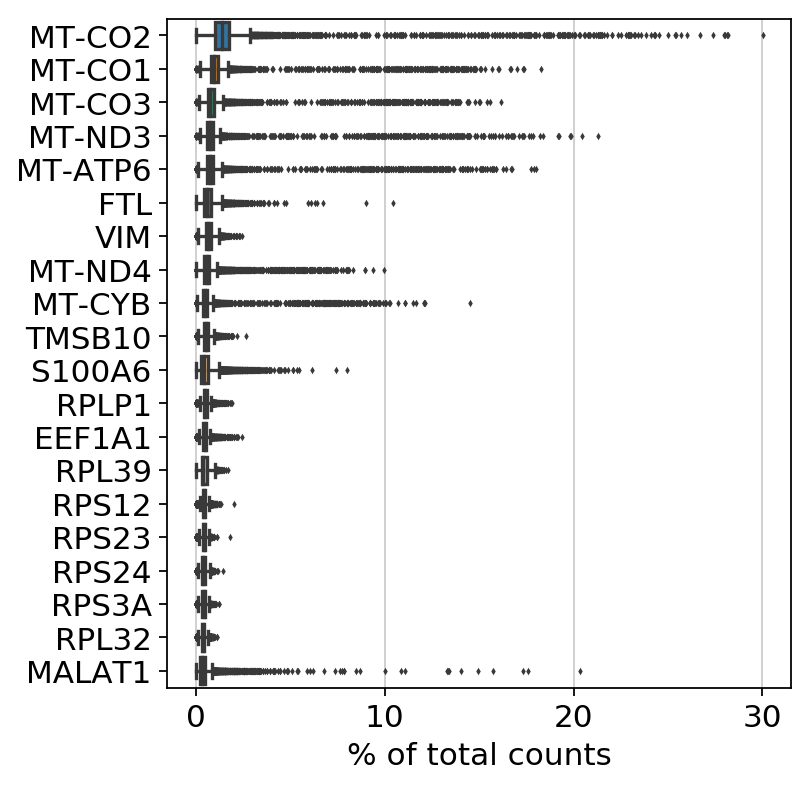

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Remove cells with fewer gene counts than a detection threshold, and are found in fewer than $n$ cells

In [18]:
adata = filter_minGenes_minCells(adata, minN_genes, minN_cells)

filtered out 97 cells that have less than 200 genes expressed
filtered out 12074 genes that are detected in less than 3 cells


Remove all cells which are not mapped to a specific sample (due to degenerate MULTI or genetic barcodes)

In [19]:
adata = keep_real_cells(adata)

### Determining % mitochondria-associated genes 

Trying to set attribute `.obs` of view, copying.
... storing 'SampleType' as categorical
... storing 'feature_types' as categorical


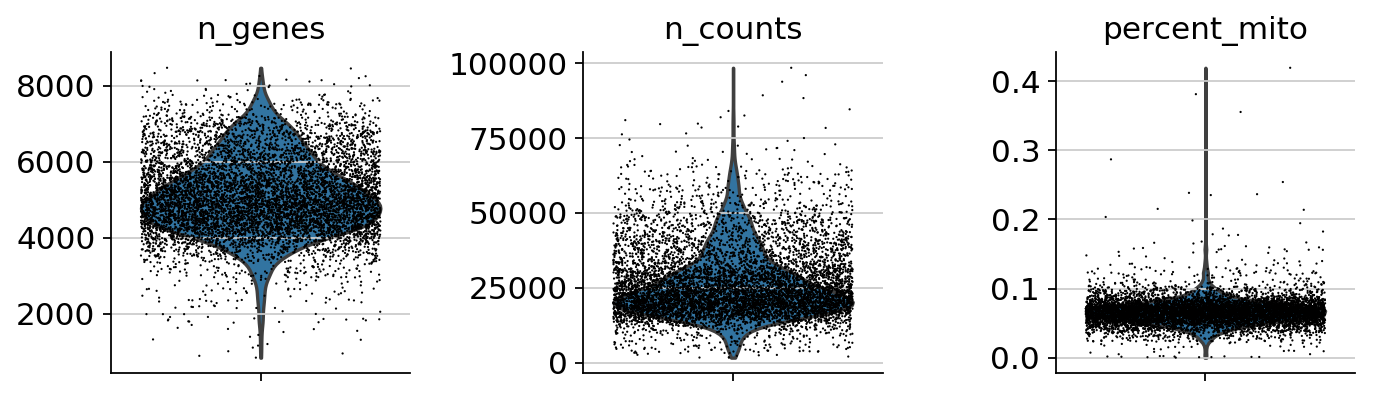

In [20]:
adata = calc_percentMito_nCounts(adata)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

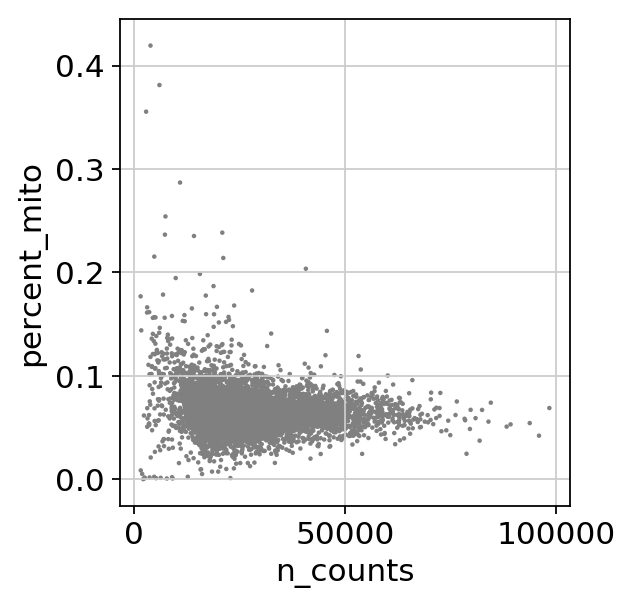

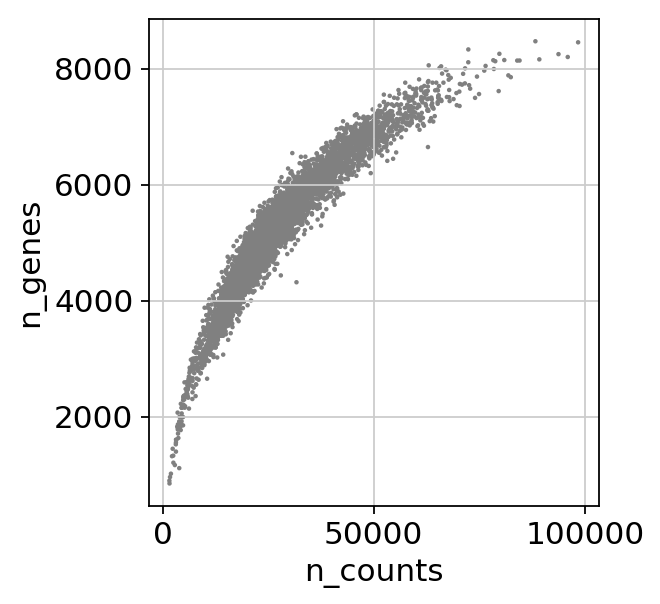

In [21]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### Filtering out cells with high gene counts, and high mitochondrial percentage

In [22]:
adata = filter_genes_mito(adata, maxN_genes, maxMito_percent)

### Normalize count matrix (Total Normalization) and log-transform the count values

In [23]:
adata, backup = normalize_and_log(adata)

normalizing counts per cell
    finished (0:00:11)


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


### Plot highly variable genes 

extracting highly variable genes
    finished (0:00:02)


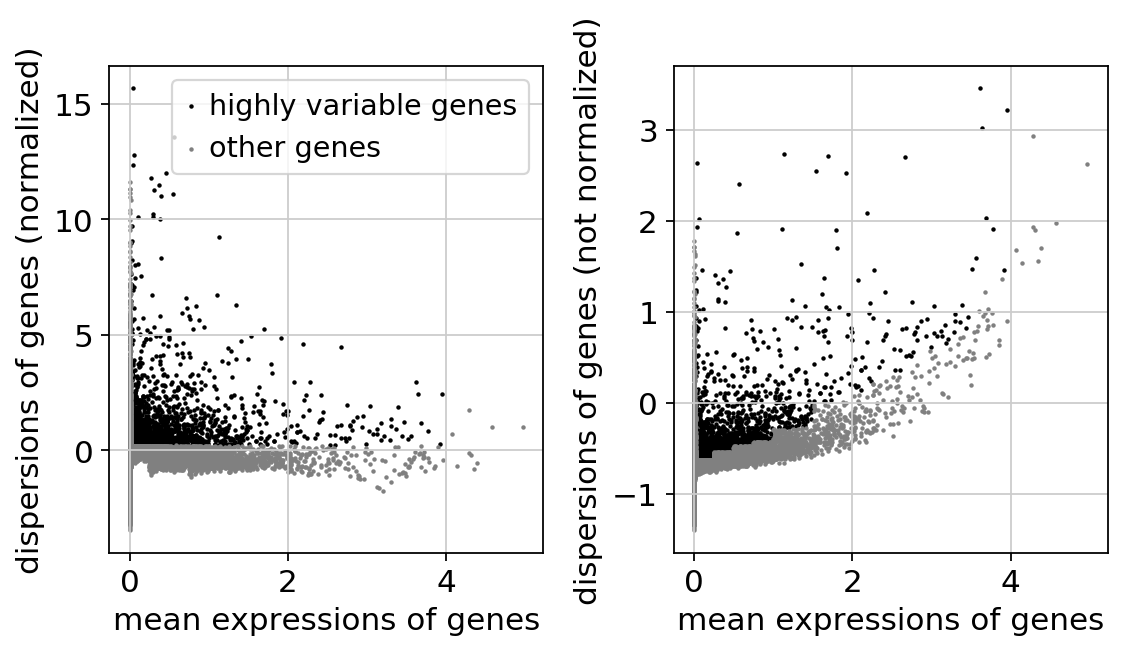

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.02, max_mean=4, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

### Keep only genes which are 'highly variable'

In [25]:
adata = adata[:, adata.var.highly_variable]

### Regress out the mitochondrial fraction and total counts, rescale the data, and perform PCA

In [26]:
adata = regress_scale_pca(adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:24)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)


In [28]:
adata

AnnData object with n_obs × n_vars = 5426 × 3254 
    obs: 'SampleType', 'quality', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [30]:
adata.write(outfilePath)